In [ ]:

import bayespy as bp


# Concentration parameter
# adding parameter to share information between the different timezones
p_conc_01 = nodes.DirichletConcentration(3)
p_conc_01.initialize_from_value(np.ones(3))
p = bp.nodes.Dirichlet(p_conc_01)
#p = bp.nodes.Dirichlet([1,1,1]) # wito
locations = bp.nodes.Categorical(p, plates=(5,))
observations = bp.nodes.Mixture(
    locations,
    bp.nodes.Bernoulli,
    [
        [0.0, 0.5, 0.5],
        [0.0, 0.5, 0.5],
        [0.0, 0.5, 0.5],
        [0.0, 0.5, 0.5],
        [0.0, 0.5, 0.0],
    ]
)
observations.observe([True, True, True, True, True])
Q = bp.inference.VB(observations, locations, p)
Q.update(repeat=10)
print(p)
print(locations)

%matplotlib inline
import bayespy.plot as bpplt
bpplt.hinton(p)
bpplt.pyplot.title("Learned Distribution ")
bpplt.pyplot.show()

# Learning from no data

The major problem we faced for the data collection in real world for the thesis was occlussion.
Consider a real world kitchen, all the objects cups, plates, bowls etc are always inside cabinets, washing machine etc occlluded from direct vision. 

We needed to learn from this non availability of data. But how can you learn when there is no data.

Lets make a small example of this problem. Our domestic robot is trying to model the object location of a cup. The cup can be on 3 locations the workspace, dishwasher or cabinet.
We start with equal probabilities as prior [0.33, 0.33, 0.33]
Now the dishwasher and the cabinet are occluded spaces and the domestic robot hardly gets any reading of the object location in these locations. But it can always see the workspace. 
The robot went to the workstation 3 times in the whole day and finds the cup only during the afternoon. Based on this observation we run our inference and the posterior probability looks like this [0.5, 0.7, 0.5] for the afternoon. No changes in the morning and the evening.

But this is the partial truth the robot saw something in morning and evening. The robot saw nothing in the morning and evening. This information can be used to infer about the probable location of the cup during the same time.



After the observation the posterior distribution decreases the probability of finding cup on workspace in morning 



   is_present     location timezone  timezone_index  location_index
10      False  counter-top    night               2               2
11      False         sink    night               2               1
12      False         sink  morning               0               1
13      False   dishwasher      day               1               0
14      False  counter-top  morning               0               2
15      False  counter-top      day               1               2
16       True      cabinet  morning               0               3
17       True  counter-top      day               1               2
18      False      cabinet    night               2               3
19      False         sink  morning               0               1
20      False  counter-top  morning               0               2
21      False         sink    night               2               1
22       True      cabinet  morning               0               3
23      False   dishwasher      day             

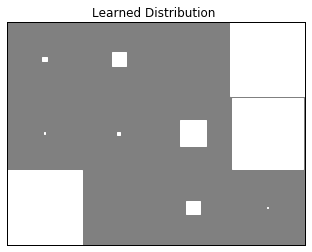

In [30]:
# Some constatnts we will be using 

n_locations = 4 #Number of colors in each bag
locations_dict = {0:'dishwasher', 1:'sink', 2:'counter-top', 3:'cabinet'}
n_timezones = 3 # Number of bags
time_dict = {0:'morning', 1:'day', 2:'night'}
n_trials = 100

from bayespy import nodes
import numpy as np
import pandas as pd

alpha = 1e-1 * np.ones(n_locations)
#Generate some random distributions for the color distribution inside each bags
p_locations = nodes.Dirichlet(alpha,
                          plates = (n_timezones,)).random()
timezone_index = nodes.Categorical((1/n_timezones)*np.ones(n_timezones), plates=(n_trials,)).random()
location_index = nodes.Categorical((1/n_locations)*np.ones(n_locations), plates=(n_trials,)).random()
is_object_present = nodes.Bernoulli(p_locations[timezone_index, location_index]).random()
#np.column_stack([time[timezone_index], locations[location_index], is_object_present])

object_location_dataset = pd.DataFrame({'is_present' : is_object_present,
                                        'timezone' : timezone_index,
                                        'location' : location_index})

object_location_dataset['timezone'] = object_location_dataset['timezone'].map(time_dict)
object_location_dataset['location'] = object_location_dataset['location'].map(locations_dict)
object_location_dataset['is_present'] = object_location_dataset['is_present'].astype(bool)

#Adding for learning without bernouli hack
object_location_dataset['timezone_index'] = timezone_index
object_location_dataset['location_index'] = location_index
print (object_location_dataset[10:])
#data["test"] = data["A"].map(map_dict)

%matplotlib inline
import bayespy.plot as bpplt
bpplt.hinton(p_locations)
bpplt.pyplot.title("Learned Distribution ")
bpplt.pyplot.show()

# Dirichlet-Categorical-Bernoulli 

With absent data learning

In [47]:
import bayespy as bp


# Concentration parameter
# adding parameter to share information between the different timezones
p_conc_01 = nodes.DirichletConcentration(n_locations)
p_conc_01.initialize_from_value(np.ones(n_locations))
#location_probabilities = [  bp.nodes.Dirichlet(p_conc_01) ] * n_timezones
location_probabilities = [] #[bp.nodes.Dirichlet([1,1,1]) ] * n_timezones # wito
location_categories = []
observations = []
for index, time in time_dict.items():
    # create location probabiliees
    location_probabilities.append(bp.nodes.Dirichlet(p_conc_01))
    #location_probabilities.append(bp.nodes.Dirichlet([0.1, 0.1, 0.1]))
    
    
    #create the updated data format
    bernoulli_data_format = np.zeros((n_trials, n_locations))
    temp = object_location_dataset[object_location_dataset['timezone'] == time].as_matrix()
    #temp = object_location_dataset[(object_location_dataset['timezone'] == time) 
    #                               & (object_location_dataset['is_present'] == True)].as_matrix()
    bernoulli_data_format = np.zeros((temp.shape[0], n_locations))
    for count, [is_present, location, _, _, _] in enumerate(temp):
        key = [key for key, location_name in locations_dict.items() if location_name == location][0]
        if is_present:
            bernoulli_data_format[count][key] = 0.5
        else :
            bernoulli_data_format[count] = 0.5
            bernoulli_data_format[count][key] = 0.0
            
    location_categories.append(bp.nodes.Categorical(location_probabilities[index],
                                                    plates=(temp.shape[0],)))
    observations.append(bp.nodes.Mixture(
                        location_categories[index],
                        bp.nodes.Bernoulli,
                        bernoulli_data_format.tolist()))
    observations[index].observe([True] * temp.shape[0])
    
   
"""
Q = bp.inference.VB(observations[0], observations[1], observations[2],
                    location_categories[0], location_categories[1], location_categories[2],
                    location_probabilities[0], location_probabilities[1], location_probabilities[2],
                    p_conc_01)
"""
Q = bp.inference.VB(observations[0], location_categories[0], location_probabilities[0], p_conc_01)
Q.update(repeat=100)
print(location_categories[0])
print(location_probabilities[0])
Q = bp.inference.VB(observations[1], location_categories[1], location_probabilities[1], p_conc_01)
Q.update(repeat=100)
print(location_probabilities[1])
Q = bp.inference.VB(observations[2], location_categories[2], location_probabilities[2], p_conc_01)
Q.update(repeat=100)
print(location_probabilities[2])

Iteration 1: loglike=-4.803112e+01 (0.018 seconds)
Iteration 2: loglike=-3.982640e+01 (0.013 seconds)
Iteration 3: loglike=-3.728451e+01 (0.009 seconds)
Iteration 4: loglike=-3.616970e+01 (0.009 seconds)
Iteration 5: loglike=-3.563132e+01 (0.009 seconds)
Iteration 6: loglike=-3.535243e+01 (0.013 seconds)
Iteration 7: loglike=-3.519984e+01 (0.016 seconds)
Iteration 8: loglike=-3.511265e+01 (0.014 seconds)
Iteration 9: loglike=-3.506105e+01 (0.016 seconds)
Iteration 10: loglike=-3.502963e+01 (0.015 seconds)
Iteration 11: loglike=-3.501007e+01 (0.009 seconds)
Iteration 12: loglike=-3.499771e+01 (0.008 seconds)
Iteration 13: loglike=-3.498979e+01 (0.008 seconds)
Iteration 14: loglike=-3.498468e+01 (0.008 seconds)
Iteration 15: loglike=-3.498137e+01 (0.009 seconds)
Iteration 16: loglike=-3.497921e+01 (0.008 seconds)
Iteration 17: loglike=-3.497781e+01 (0.008 seconds)
Iteration 18: loglike=-3.497689e+01 (0.008 seconds)
Iteration 19: loglike=-3.497628e+01 (0.008 seconds)
Iteration 20: loglike

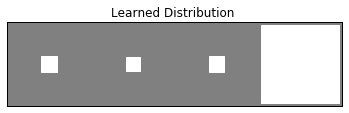

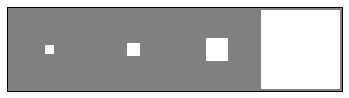

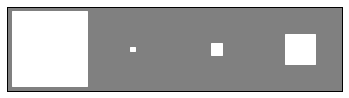

In [46]:
%matplotlib inline
import bayespy.plot as bpplt
bpplt.pyplot.title("Learned Distribution ")
bpplt.hinton(location_probabilities[0])
bpplt.pyplot.show()
bpplt.hinton(location_probabilities[1])
bpplt.pyplot.show()
bpplt.hinton(location_probabilities[2])
bpplt.pyplot.show()

In [33]:

for index in time_dict.keys():
    beta = p_locations[index]
    alpha = location_probabilities[index].get_parameters()[0]

    D = np.log2(0.5*sum(alpha) + 0.5*sum(beta)) + \
        0.5*sum(np.log2(alpha)) + 0.5*sum(np.log2(beta)) - \
        sum(np.log2(np.add(alpha, beta) / 2)) - \
        0.5 * np.log2(sum(alpha)) + \
        0.5 * np.log2(sum(beta))
        
    print (' Bhatta KL  :', D)

 Bhatta KL  : -9.99513130641
 Bhatta KL  : -8.04448695221
 Bhatta KL  : -49.7242529725


T.W. Rauber, A. Conci, T. Braun, and K. Berns.  Bhattacharyya probabilistic
distance of the dirichlet density and its application to split-and-merge image seg-
mentation. In
WSSIP08
, pages 145–148, 2008.

Bhattacharyya distance
We adopt the Bhattacharyya distance [4] to quantify the similarity between at-
tack types distributions. The Bhattacharyya distance is a measure of divergence
between probability distributions, that allows measuring the dissimilarity be-
tween two continuous or discrete probability distributions. As such, it goes from
zero (when the compared distributions are identical) to infinite (when there is
no overlap between the compared distributions). For continuous probability dis-
tributions, it is defined as follows:

![](images/bhatta-Dirichlet.png)

In [22]:
# Comparing KL Divergancedirichlet 
'''
http://bariskurt.com/kullback-leibler-divergence-between-two-dirichlet-and-beta-distributions/
'''
import scipy.special

for index in time_dict.keys():
    alpha = p_locations[index]
    beta = location_probabilities[index].get_parameters()[0]
    D = scipy.special.gammaln(sum(alpha)) - \
        scipy.special.gammaln(sum(beta)) - \
        sum(scipy.special.gammaln(alpha)) + \
        sum(scipy.special.gammaln(beta)) +  \
        (alpha - beta) * (scipy.special.psi(alpha) - scipy.special.psi(sum(alpha)))
    print ('D : ', D)

D :  [  7.13748557e+11   9.77128868e+04  -7.94493136e+01   2.04221363e+14]
D :  [ -2.18309376e+01   3.91040692e+03   2.35434293e+00   2.79512098e+03]
D :  [  2.02222039e+01  -4.29992846e+01   2.04464034e+07  -1.30303229e+01]


In [23]:
# Bhattacharya distance

from scipy.special import gammaln
import numpy as np

alpha = p_locations[0]
beta = location_probabilities[0].get_parameters()[0]
beta = alpha
'''
D = - gammaln(sum(np.add(alpha, beta)/2)) + \
    0.5*(sum(gammaln(alpha)) + sum(gammaln(beta))) - \
    sum(gammaln(np.add(alpha, beta) / 2)) -  \
    0.5*(gammaln(alpha) + gammaln(beta))
'''  
D = - np.log2(sum(np.add(alpha, beta)/2)) + \
    0.5*(sum(np.log2(alpha)) + sum(np.log2(beta))) - \
    sum(np.log2(np.add(alpha, beta) / 2)) -  \
    0.5*(np.log2(alpha) + np.log2(beta))
print (D)

[  4.01354641e+01   1.72564310e+01   9.21451830e-06   4.83630615e+01]


# Dirichlet-Categorical Distribution

Iteration 1: loglike=-3.309852e+01 (0.003 seconds)
Iteration 2: loglike=-3.309852e+01 (0.002 seconds)
Converged at iteration 2.


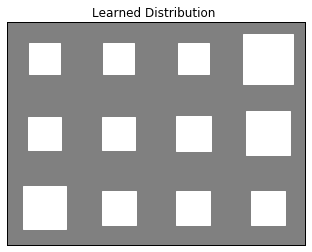

In [38]:

p_conc = bp.nodes.DirichletConcentration(n_locations)
p_conc.initialize_from_value(np.ones(n_locations))
#p_theta = bp.nodes.Dirichlet(p_conc,
p_theta = bp.nodes.Dirichlet(np.ones(n_locations)*10,
                          plates=(n_timezones,),
                          name='p_theta')

only_true_object_location = object_location_dataset[object_location_dataset['is_present'] == True]
n_observations = only_true_object_location.shape[0]
recordings_time = only_true_object_location['timezone_index'].as_matrix().reshape((n_observations, 1))

Y = nodes.Mixture(recordings_time, nodes.Categorical, p_theta)

#Observe Data
Y.observe(only_true_object_location['location_index'].reshape((n_observations, 1)))

#Inference
#Q = bp.inference.VB(Y, p_theta, p_conc)
Q = bp.inference.VB(Y, p_theta)
Q.update(repeat=1000)


%matplotlib inline
import bayespy.plot as bpplt
bpplt.hinton(p_theta)
bpplt.pyplot.title("Learned Distribution ")
bpplt.pyplot.show()

In [48]:
for index in time_dict.keys():
    beta = p_locations[index]
    alpha = p_theta.get_parameters()[0][0]

    D1 = np.log2(0.5*sum(alpha) + 0.5*sum(beta)) + \
        0.5*sum(np.log2(alpha)) + 0.5*sum(np.log2(beta)) - \
        sum(np.log2(np.add(alpha, beta) / 2)) - \
        0.5 * np.log2(sum(alpha)) + \
        0.5 * np.log2(sum(beta))

    beta = p_locations[index]
    alpha = location_probabilities[index].get_parameters()[0]

    D2 = np.log2(0.5*sum(alpha) + 0.5*sum(beta)) + \
        0.5*sum(np.log2(alpha)) + 0.5*sum(np.log2(beta)) - \
        sum(np.log2(np.add(alpha, beta) / 2)) - \
        0.5 * np.log2(sum(alpha)) + \
        0.5 * np.log2(sum(beta))
        
    print (' With only present data  : ', D1, " with both data  ", D2 )

 With only present data  :  -15.2622384106  with both data   -9.99513130641
 With only present data  :  -13.0901816038  with both data   -8.04448695221
 With only present data  :  -55.1087281689  with both data   -49.7242529725


# Using concentration + beta-bernoulli